In [ ]:
import os
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib import TaskType
import torch

import platform

def isLinux():
    os_name = platform.system()
    if os_name.lower() == 'windows': return False
    if os_name.lower() == 'linux': return True

seed = 67
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('medium')


class ExtractBChannel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 可以在这里设置一些参数（如果需要的话），例如大小，填充值等
        pass
    
    # RGB (N, 3, H, W) 的tensor类型
    def forward(self, img):
        
        tmp_img = img.clone()
        if len(img.shape) == 3: tmp_img = tmp_img.unsqueeze(0)
        bs, channels, height, width = tmp_img.shape
        
        if channels == 1: tmp_img = tmp_img.repeat(1,3,1,1)
        
        b_channel = tmp_img[:, 2, :, :]     # 提取 B 通道（张量的第三个通道，索引为2）
        b_channel[b_channel < 100/255] = 0
        # b_channel[b_channel >= 100/255] = 1    # 不能添加
        b_channel_3 = b_channel.repeat(1, 3, 1, 1)
        
        out_img = b_channel_3
        if len(img.shape) == 3: out_img = out_img.squeeze(0)
        
        print("{} --> {} --> {} -- {};".format(img.shape, tmp_img.shape, b_channel.shape, out_img.shape))
        return out_img

In [15]:
from lightning.pytorch.callbacks import EarlyStopping
from anomalib.callbacks.checkpoint import ModelCheckpoint
from anomalib.callbacks import GraphLogger
from anomalib.loggers import AnomalibMLFlowLogger
from torchvision.transforms.v2 import Resize, RandomHorizontalFlip, Compose, Normalize, ToDtype,RandomAffine,RandomPerspective, Grayscale, ToTensor, Transform, GaussianBlur
from anomalib.data.image.folder import Folder, FolderDataset

import warnings
warnings.filterwarnings("ignore")




# read_image,会自动将数据类型转换为float32,但不会进行255归一化
train_transform = Compose(
    [
        ExtractBChannel(),          # 0~1之间
        # ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 306)),
        RandomHorizontalFlip(p=0.3),   # 无seed, 0.90 --> 0.95
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ),  # onnx 不支持 grid_sampler.
        RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True),  # Normalize expects float input
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)

eval_transform = Compose(
    [
        ExtractBChannel(),          # 0~1之间
        # ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 306)),
        #RandomHorizontalFlip(p=0.3),   # 无seed, 0.90 --> 0.95
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ),  # onnx 不支持 grid_sampler.
        #RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True),  # Normalize expects float input
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)


In [16]:
def draw_pic(inferencer, png_files, input_path, outpath):
    from anomalib.data.utils import read_image
    import time
    import matplotlib.pyplot as plt


    for file_name in png_files:
            
        image = read_image(path=os.path.join(input_path, file_name))                     # HWC
        CHW_image = read_image(path=os.path.join(input_path, file_name),as_tensor=True)  # CHW
        

        # 记录开始时间
        start_time = time.time()
        predictions = inferencer.predict(image=image)
        filter_image = ExtractBChannel()(CHW_image)  # CHW -> CHW
        filter_image = filter_image.permute(1,2,0)    # CHW -> HWC
        
        train_image = train_transform(CHW_image)  # CHW -> CHW
        train_image = train_image.permute(1,2,0)    # CHW -> HWC
        
        print("image: {}; filter_image: {}; train_image: {}; predictions.heat_map: {};".format(image.shape, filter_image.shape, train_image.shape, predictions.heat_map.shape))
        
        
        # 记录结束时间
        end_time = time.time()

        # 计算耗时
        elapsed_time = end_time - start_time
        print(f"Prediction took {elapsed_time:.4f} seconds.")
        print(predictions.pred_score, predictions.pred_label)
        # 创建一个新的图形窗口
        fig, axs = plt.subplots(1, 5, figsize=(18, 6))  # 创建一个1行3列的子图网格

        # 原始图像
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        axs[1].imshow(filter_image.numpy())
        axs[1].set_title('Filter Image')
        axs[1].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        axs[2].imshow(train_image.numpy())
        axs[2].set_title('Train Image')
        axs[2].axis('off')  # 关闭坐标轴

        # 热图
        axs[3].imshow(predictions.heat_map, cmap='hot', interpolation='nearest')
        axs[3].set_title('Heat Map')
        axs[3].axis('off')  # 关闭坐标轴

        # 预测掩模
        axs[4].imshow(predictions.pred_mask, cmap='gray', interpolation='nearest')
        axs[4].set_title('Predicted Mask')
        axs[4].axis('off')  # 关闭坐标轴


        # 添加文本信息到图形的上方中间位置
        fig_text_x = 0.1  # x坐标在图形宽度的中心位置
        fig_text_y = 0.95  # y坐标稍微靠近图形的顶部，避免与子图重叠
        fig.text(fig_text_x, fig_text_y,
                f'Prediction Time: {elapsed_time:.4f} s\n'
                f'Predicted Class: {predictions.pred_label}\n'
                # f'Score: {predictions.pred_score:.4f}\n'
                f'Threshold: {predictions.pred_score:.4f}' if hasattr(predictions, 'pred_score') else '',
                ha='left', va='center', fontsize=12,
                bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5))  

        # 显示整个图形
        plt.tight_layout()  # 调整子图间的间距
        #plt.show()
        plt.savefig(os.path.join(outpath, file_name))
        plt.close()
        
    print("Done")

In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def pplot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## 参数配置

In [ ]:
configs = {
    "dataset_root": r"/local_data/datasets/3-5-jing" if isLinux() else r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing",
    "outputs_path": r"/local_data/datasets/3-5-jing/outputs" if isLinux() else r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing\outputs",
    "model_name": "Patchcore",
}

dataset_root = configs["dataset_root"]
print("dataset_root: {}".format(dataset_root))

normal_folder_path = os.path.join(configs["dataset_root"], "normal")
abnormal_folder_path = os.path.join(configs["dataset_root"], "abnormal")

normal_ouput_path = os.path.join(configs["outputs_path"], configs["model_name"] , "normal_outputs")
abnormal_output_path = os.path.join(configs["outputs_path"], configs["model_name"] , "abnormal_outputs")

dataset_root: /local_data/datasets/3-5-jing


## Custom 数据集配置

In [19]:



folder_datamodule = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal", abnormal_dir="abnormal",
    task=TaskType.CLASSIFICATION,
    num_workers=0,          # in jupyter, need to be zero. and can be non-0 in python main.py;
    # image_size=(256, 256),
    train_batch_size = 16, eval_batch_size = 8,                     # 计算的时候会使用cuda，因此需要限制BS不适用默认值32；
    train_transform=train_transform, eval_transform=eval_transform,
    seed = seed,
)

folder_datamodule.setup()            #! 进行数据集分割

INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20


==> 检查训练集、验证集、测试集的数据量

In [20]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3

In [21]:
# # Train images
# i, data = next(enumerate(folder_datamodule.val_dataloader()))
# print(data.keys(), data["image"].shape)

In [22]:
# # Test images
# i, data = next(enumerate(folder_datamodule.test_dataloader()))
# print(data.keys(), data["image"].shape)

==> 查看图像内容

In [23]:
# img = to_pil_image(data["image"][0].clone())
# Image.fromarray((np.array(img)))

In [24]:
from anomalib.data.utils import read_image
#test_image = read_image(r"F:\Projects\anomalib\notebooks\datasets\3-5\normal\1__DA2951175 (2).png", as_tensor=True)
test_image = read_image(r"/local_data/datasets/3-5-jing/normal/1__DA2951175 (2).png", as_tensor=True)
print("处理前的数据: ",test_image.min(), test_image.max(), test_image.mean())



for trans in train_transform.transforms:
    tmp_image = trans(test_image)
    print(tmp_image.min(), tmp_image.max(), tmp_image.mean())

处理前的数据:  tensor(0.) tensor(0.9725) tensor(0.0655)
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
tensor(0.) tensor(0.9725) tensor(0.0457)
tensor(0.) tensor(0.9362) tensor(0.0655)
tensor(0.) tensor(0.9725) tensor(0.0655)
tensor(0.) tensor(0.9725) tensor(0.0655)
tensor(-1.8044) tensor(2.5180) tensor(-1.5135)


torch.Size([16, 3, 256, 306])
tensor(-1.8044) tensor(1.6501)
tensor(-1.8044) tensor(1.9774)
tensor(-1.8044) tensor(2.4463)
tensor(-1.8044) tensor(2.4919)
tensor(-1.8044) tensor(2.4152)
tensor(-1.8044) tensor(2.2764)
tensor(-1.8044) tensor(1.7671)
tensor(-1.8044) tensor(2.4152)
tensor(-1.8044) tensor(2.2622)
tensor(-1.8044) tensor(2.1572)
tensor(-1.8044) tensor(2.4533)
tensor(-1.8044) tensor(1.7715)
tensor(-1.8044) tensor(2.0561)
tensor(-1.8044) tensor(2.1324)
tensor(-1.8044) tensor(1.6901)
tensor(-1.8044) tensor(2.1258)


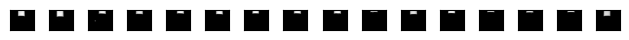

In [25]:
total_images = []
print(data["image"].shape)
for i in range(data["image"].shape[0]):
    test_img = data["image"][i]
    total_images.append(test_img)
    print(test_img.min(), test_img.max())

pplot(total_images)

## 模型选择和优化器配置

In [26]:
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore, Stfpm, Fastflow
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"



model_checkpoint = ModelCheckpoint(mode="max", monitor="image_F1Score")
early_stopping = EarlyStopping(monitor="image_F1Score", mode="max", patience=3)

graph_logger = GraphLogger()
callbacks = [
    model_checkpoint,
    early_stopping,
    graph_logger,
]




if configs["model_name"] == "Patchcore":
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION, image_metrics=["F1Score","AUROC"], pixel_metrics=["F1Score","AUROC"], callbacks= callbacks)
    engine.train(datamodule=folder_datamodule, model=model)
elif configs["model_name"] == "Fastflow":
    model = Fastflow()
    engine = Engine(
    pixel_metrics="AUROC",
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    logger=False,
    task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model, train_dataloaders=folder_datamodule.train_dataloaders, val_dataloaders=folder_datamodule.val_dataloaders, test_dataloaders=folder_datamodule.val_dataloaders)
else:
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION)
    engine.train(datamodule=folder_datamodule, model=model)
    

print(engine.trainer.default_root_dir)

INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.20
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | trai

Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.patchcore.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.patchcore.lightning_model:Applying core-set subsampling to get the embedding.









































































































































Selecting Coreset Indices.: 100%|██████████| 10233/10233 [00:13<00:00, 741.47it/s]


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 48.33 seconds
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3

INFO:anomalib.callbacks.timer:Testing took 21.581111431121826 seconds
Throughput (batch_size=8) : 1.7144622100714797 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.970370352268219     │
│       image_F1Score       │    0.9259259104728699     │
└───────────────────────────┴───────────────────────────┘

/home/projects/results/Patchcore/3-5/latest


## 模型导出

In [ ]:
# from anomalib.deploy import ExportType
# engine.export(model=model, export_type=ExportType.OPENVINO)  # torch.onnx.export op=16
# print(f"Model save to {engine.trainer.default_root_dir}).") 

from anomalib.deploy import ExportType
engine.export(model=model, export_type=ExportType.ONNX)  # torch.onnx.export op=16
print(f"Model save to {engine.trainer.default_root_dir}).") 

opset_versissssson: 14;
torch.Size([1, 3, 1, 1]) --> torch.Size([1, 3, 1, 1]) --> torch.Size([1, 1, 1]) -- torch.Size([1, 3, 1, 1]);


INFO:root:Exported model to F:\Projects\anomalib\notebooks\100_datamodules\results\Patchcore\3-5\latest\weights\onnx\model.onnx


Model save to F:\Projects\anomalib\notebooks\100_datamodules\results\Patchcore\3-5\latest).


In [ ]:
# model_output_path=Path(engine.trainer.default_root_dir)
# openvino_model_path = model_output_path / "weights" / "openvino" / "model.bin"
# metadata_path = model_output_path / "weights" / "openvino" / "metadata.json"
# print(openvino_model_path.exists(), metadata_path.exists())

model_output_path=Path(engine.trainer.default_root_dir)
openvino_model_path = model_output_path / "weights" / "onnx" / "model.onnx"
metadata_path = model_output_path / "weights" / "onnx" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())


True True


## 模型测试

In [ ]:
from anomalib.deploy import OpenVINOInferencer
inferencer = OpenVINOInferencer(
    path=openvino_model_path,    # Path to the OpenVINO IR model.
    metadata=metadata_path,      # Path to the metadata file.
    device="AUTO",               # We would like to run it on an Intel CPU.
)

In [ ]:
# 待测试图像
normal_png_files = [f for f in os.listdir(normal_folder_path) if f.endswith('.png')]
abnormal_png_files = [f for f in os.listdir(abnormal_folder_path) if f.endswith('.png')]
print(normal_png_files)
print(abnormal_png_files)


import shutil
# 输出路径确认
if os.path.exists(normal_ouput_path): 
    shutil.rmtree(normal_ouput_path)
if os.path.exists(abnormal_output_path): 
    shutil.rmtree(abnormal_output_path)
os.makedirs(normal_ouput_path)
os.makedirs(abnormal_output_path)


# 模型测试
draw_pic(inferencer, normal_png_files, normal_folder_path, normal_ouput_path)
draw_pic(inferencer, abnormal_png_files, abnormal_folder_path, abnormal_output_path)

['11__DA1479053.png', '11__DA2951175.png', '11__DA2951215 (2).png', '11__DA2951215 (3).png', '11__DA2951215 (4).png', '11__DA2951215.png', '11__DA2951225 (2).png', '11__DA2951225.png', '13__DA1479053.png', '13__DA2951175.png', '13__DA2951225.png', '15__DA1479053.png', '15__DA2951175.png', '15__DA2951215 (3).png', '15__DA2951225.png', '17__DA1479053 (2).png', '17__DA1479053.png', '17__DA2951175.png', '17__DA2951215 (2).png', '17__DA2951215 (3).png', '17__DA2951215.png', '17__DA2951225.png', '19__DA1479053 (2).png', '19__DA1479053.png', '19__DA2951175 (2).png', '19__DA2951175 (3).png', '19__DA2951175.png', '19__DA2951215 (2).png', '19__DA2951215 (3).png', '19__DA2951215.png', '19__DA2951225.png', '1__DA2951175 (2).png', '1__DA2951175 (3).png', '1__DA2951175.png', '1__DA2951215 (2).png', '1__DA2951225.png', '3__DA2951175 (2).png', '3__DA2951175 (3).png', '3__DA2951175.png', '3__DA2951215 (2).png', '3__DA2951215.png', '3__DA2951225.png', '53__DA1479053.png', '53__DA2951175.png', '53__DA295

torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4950 seconds.
0.5694583725118074 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4941 seconds.
0.5407965599605364 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4808 seconds.
0.5989415447200175 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5691 seconds.
0.4700477967415926 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.8656 seconds.
0.5533738539708989 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5229 seconds.
0.4700477967415926 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.7134 seconds.
0.6245607212381873 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5802 seconds.
0.6403223858011913 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5315 seconds.
0.5826052530452418 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5672 seconds.
0.6414014135177654 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5004 seconds.
0.4659918315124278 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4595 seconds.
0.3583629176020946 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4797 seconds.
0.3815431326592386 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4855 seconds.
0.5869021413275134 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5106 seconds.
0.6195386716528056 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5556 seconds.
0.5696673433585802 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5783 seconds.
0.4572782768909854 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4811 seconds.
0.44321127533557936 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5926 seconds.
0.5121215906184221 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5197 seconds.
0.5490904642142979 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5048 seconds.
0.5121215906184221 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5351 seconds.
0.4974735544232362 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5478 seconds.
0.4035862677960547 LabelName.NORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5308 seconds.
0.5242395930211597 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4271 seconds.
0.45749553480731536 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4909 seconds.
0.37625918604573677 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5898 seconds.
0.45749553480731536 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5228 seconds.
0.46766974951349777 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4880 seconds.
0.46766974951349777 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5027 seconds.
0.5802813707872425 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5438 seconds.
0.6031580398842133 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5170 seconds.
0.3659286703730087 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5052 seconds.
0.43047451931152053 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5073 seconds.
0.3659286703730087 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5034 seconds.
0.5642714358723491 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5085 seconds.
0.5403063413510589 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4826 seconds.
0.4245391834007092 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4791 seconds.
0.4964309214657485 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5070 seconds.
0.4245391834007092 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4808 seconds.
0.5730600867220471 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5455 seconds.
0.5730600867220471 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5649 seconds.
0.5631186788668279 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5043 seconds.
0.5590038498136947 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4991 seconds.
0.5027642930164267 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5279 seconds.
0.5107931819117706 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5940 seconds.
0.6752654553420073 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6508 seconds.
0.6111174711759488 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5728 seconds.
0.4427208858586882 LabelName.NORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.7191 seconds.
0.49753600646288904 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4581 seconds.
0.6278453909625833 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4775 seconds.
0.43804757666436395 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5282 seconds.
0.5940717380001097 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6300 seconds.
0.4766959060680315 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6046 seconds.
0.5251304957154141 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5519 seconds.
0.4980562977371516 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4948 seconds.
0.6178515268114039 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4983 seconds.
0.495030577577992 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5438 seconds.
0.4615768738473925 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4843 seconds.
0.495030577577992 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4915 seconds.
0.5305968005760282 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5179 seconds.
0.4076061372841069 LabelName.NORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5087 seconds.
0.5305968005760282 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4737 seconds.
0.4921768354705714 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4629 seconds.
0.4921768354705714 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4998 seconds.
0.6260696513672555 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5309 seconds.
0.4858387650660206 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5168 seconds.
0.5573471193719051 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5787 seconds.
0.4910598751881891 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4823 seconds.
0.40980212528306326 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4962 seconds.
0.3780096372638591 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5744 seconds.
0.4629392851693407 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5371 seconds.
0.5131357741515535 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5428 seconds.
0.599559230420004 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5069 seconds.
0.44718505333882613 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4598 seconds.
0.3978288902964567 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4631 seconds.
0.6294725613418286 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4728 seconds.
0.4374775629727581 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5306 seconds.
0.5663732759264388 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5206 seconds.
0.43502980183993445 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5294 seconds.
0.607279532766475 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5329 seconds.
0.4989083280948232 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4614 seconds.
0.7367778950877498 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5207 seconds.
0.5125589257634057 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5496 seconds.
0.45870322568629324 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5689 seconds.
0.4202715561630082 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.8320 seconds.
0.7482855590892835 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5663 seconds.
0.5479507785659132 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4680 seconds.
0.5479507785659132 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5104 seconds.
0.5160851165768559 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5824 seconds.
0.4882225363524694 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5346 seconds.
0.6562232218725326 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4555 seconds.
0.4882225363524694 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4855 seconds.
0.44781299108362577 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5040 seconds.
0.5442740535611247 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5101 seconds.
0.48653504977624057 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.6121 seconds.
0.48653504977624057 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5261 seconds.
0.45663965993283884 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5312 seconds.
0.49565578144417477 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5361 seconds.
0.5111345750040452 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5224 seconds.
0.49565578144417477 LabelName.NORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5719 seconds.
0.7111651260975882 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4753 seconds.
0.5732257426794847 LabelName.ABNORMAL
Done


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5083 seconds.
1.0 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5129 seconds.
0.8046047401012663 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4930 seconds.
0.8046047401012663 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5182 seconds.
1.0 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4706 seconds.
0.8176556785819918 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5336 seconds.
0.8176556785819918 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5348 seconds.
0.9885605975301799 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5043 seconds.
0.9686263507282625 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5832 seconds.
0.9686263507282625 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5102 seconds.
0.9686263507282625 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5048 seconds.
1.0 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4544 seconds.
1.0 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5843 seconds.
0.6607154116084929 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4742 seconds.
0.8388695514439919 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5264 seconds.
0.6607154116084929 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5959 seconds.
0.7919045924205608 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5153 seconds.
0.7919045924205608 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4598 seconds.
0.839436831256981 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5724 seconds.
0.839436831256981 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5555 seconds.
0.839436831256981 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5041 seconds.
0.6815652514459227 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5267 seconds.
0.6815652514459227 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5368 seconds.
0.7130667949767031 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.4923 seconds.
0.7130667949767031 LabelName.ABNORMAL
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 1.0839 seconds.
0.7130667949767031 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5984 seconds.
0.8077757829956509 LabelName.ABNORMAL


torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
image: (2048, 2448, 3); filter_image: torch.Size([2048, 2448, 3]); train_image: torch.Size([256, 306, 3]); predictions.heat_map: (2048, 2448, 3);
Prediction took 0.5308 seconds.
0.8077757829956509 LabelName.ABNORMAL


KeyboardInterrupt: 

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.


We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [ ]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task


In [ ]:
folder_dataset_classification_train = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="train",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_train.samples.head()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

Let's look at the first sample in the dataset.


In [ ]:
data = folder_dataset_classification_train[0]
print(data.keys(), data["image"].shape)
import matplotlib.pyplot as plt
plt.imshow(data["image"][2])   # RGB

As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [ ]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    name="3-5",
    normal_dir=dataset_root / "normal",
    abnormal_dir=dataset_root / "abnormal",
    split="test",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_test.samples.head()

In [ ]:
data = folder_dataset_classification_test[0]
print(data.keys(), data["image"].shape, data["image_path"], data["label"])